In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import sys
import seaborn as sns
path = r"../../../modules"
sys.path.append(path)
from simulation_tools import get_gbms
from FTMO_optimization import FTMOLeverageOptimazation

In [2]:
data = pd.read_csv('portfolio_values.csv',index_col='date', parse_dates=True)

In [3]:
first_date = data[data.pf_value == 100000].iloc[-1].name
data = data.loc[first_date:]
data = data.resample('H', label='right').last().dropna()
data['returns'] = data['pf_value'].pct_change()
data = data.dropna()

# Calcule des rentabilités annuelles, de la volatilité et du ratio de Sharpe

In [4]:
DAYS = 252
HOURS = 24
bars_in_years = DAYS * HOURS
annual_returns = np.product(data.returns.values + 1)**(bars_in_years/len(data)) - 1
annual_volatility = data.returns.std() * np.sqrt(bars_in_years)

In [5]:
sharpe_ratio = annual_returns/annual_volatility

In [6]:
annual_mu = data.returns.mean() * bars_in_years

# Calcule de la VaR 1j, 10j analytiquement
# Calcule de la CVaR 1 an par simulation
# Calcule des drawdowns max et du ratio de Calmar par simulation

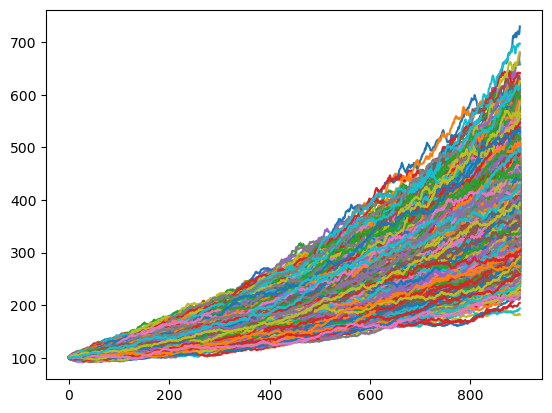

In [7]:
plt.plot(get_gbms(mu=annual_mu, sigma=annual_volatility, n_sim=10000, S0=100, time_in_days=900))
plt.show()

In [8]:
daily_returns = data.pf_value.resample('D', label='right').last().dropna().pct_change().dropna()

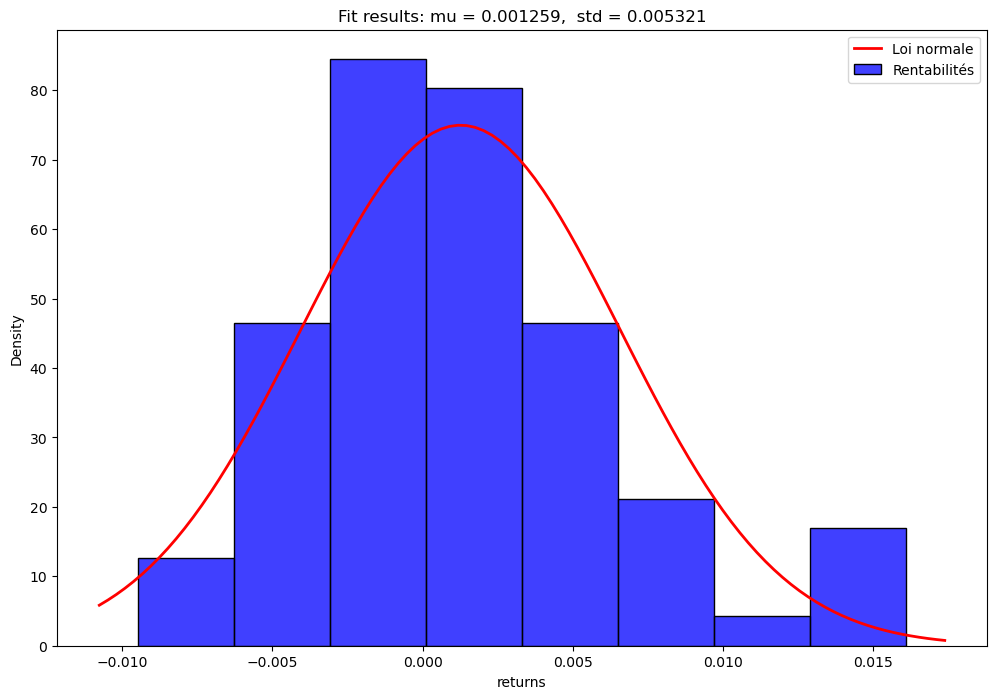

In [9]:
def plot_pdf_returns(returns, JSU=False):
    mu, std = sps.norm.fit(returns.dropna())
    plt.figure(figsize=(12, 8))
    sns.histplot(returns.dropna(), 
                 bins=8,
                 kde=False, 
                 color='blue', 
                 label='Rentabilités', 
                 stat='density')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = sps.norm.pdf(x, mu, std)
    if JSU:
        p_SU = sps.johnsonsu.pdf(x, a, b, loc, scale)
        plt.plot(x, p_SU, linewidth=2, color='purple', label='Loi de Johnson SU')
    plt.plot(x, p, linewidth=2, color='red', label='Loi normale')
    title = "Fit results: mu = %.6f,  std = %.6f" % (mu, std)
    plt.title(title)
    plt.xlabel('returns')
    plt.legend()
    plt.show()

plot_pdf_returns(daily_returns)

In [10]:
print(f"Skew of daily returns : {sps.skew(daily_returns)}")
print(f"Skew of Hourly returns : {sps.skew(data.returns.replace(0, np.nan).dropna())}")

Skew of daily returns : 0.7253977607184738
Skew of Hourly returns : 0.0811514954216886


In [11]:
jb_stat, jb_pvalue = sps.jarque_bera(daily_returns)
print(f"JB statistic: {jb_stat}")
print(f"JB p-value: {jb_pvalue}")

JB statistic: 8.658432082035443
JB p-value: 0.013177874354599382


### Pour les VaR analytiques on va prendre une loi de Johnson SU et la methode de cornish-fisher 

In [12]:
a, b, loc, scale = sps.johnsonsu.fit(daily_returns)
loc_10, scale_10 = loc * 10, scale * np.sqrt(10)
VaRSU_99p = sps.johnsonsu.ppf(0.01, a=a, b=b, loc=loc, scale=scale)
VaRSU_95p_10j = sps.johnsonsu.ppf(0.01, a=a, b=b, loc=loc_10, scale=scale_10)

In [13]:
print(f'Johnson SU Value at Risk, 95%, 10 days : {-VaRSU_95p_10j}')
print(f'Johnson SU Value at Risk, 99%, 1 days : {-VaRSU_99p}')

Johnson SU Value at Risk, 95%, 10 days : 0.04856794331324713
Johnson SU Value at Risk, 99%, 1 days : 0.009813008749407347


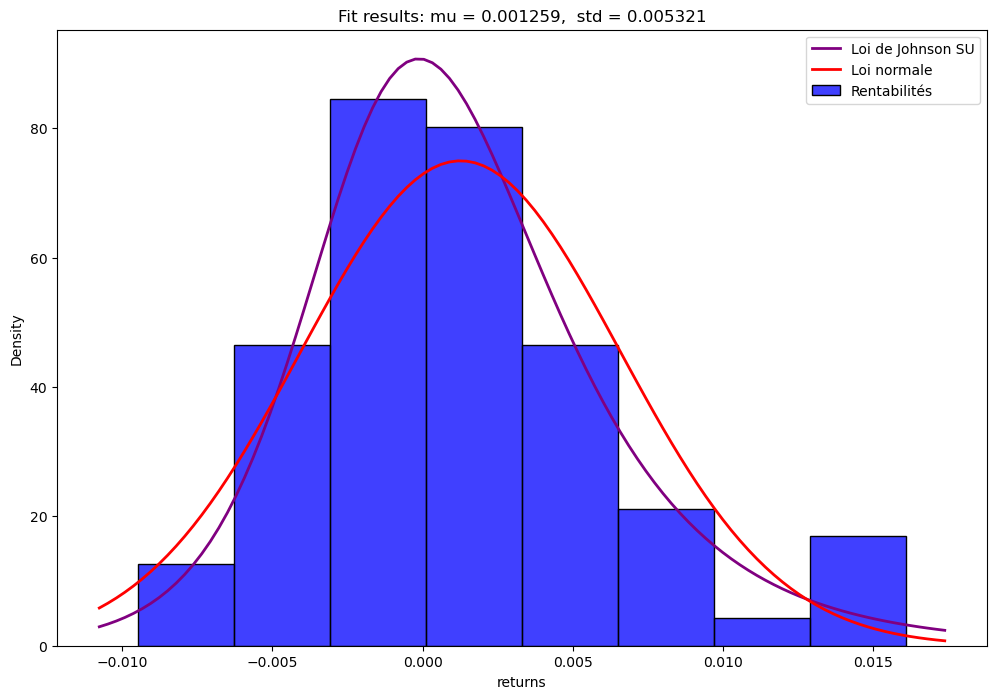

In [14]:
plot_pdf_returns(daily_returns, JSU=True)

In [15]:
def z_p(alpha_p, sk, k):
    return (alpha_p + 1/6 * (alpha_p ** 2 - 1) * sk + 1/24 * 
            (alpha_p**3 - 3 * alpha_p) * k - 1/36 * 
            (2*alpha_p**3 - 5 * alpha_p) * sk**2)

skew = sps.skew(daily_returns)
kurt = sps.kurtosis(daily_returns)
alpha_99 = sps.norm.ppf(0.01)
alpha_95 = sps.norm.ppf(0.05)
z_99 = z_p(alpha_99, skew, kurt)
z_95 = z_p(alpha_95, skew, kurt)

MVaR_99 = np.mean(daily_returns) + np.std(daily_returns) * z_99
MVaR_95_10d = np.mean(daily_returns) * 10 + np.std(daily_returns) * z_95 * np.sqrt(10)

In [16]:
print(f'Cornish-Fisher Value at Risk, 95%, 10 days : {-MVaR_95_10d}')
print(f'Cornish-Fisher Value at Risk, 99%, 1 days : {-MVaR_99}')

Cornish-Fisher Value at Risk, 95%, 10 days : 0.01116238693753876
Cornish-Fisher Value at Risk, 99%, 1 days : 0.008270341321060876


In [17]:
simulations = get_gbms(mu=annual_mu, sigma=annual_volatility, n_sim=1000, S0=100, time_in_days=252)
simulations_returns = np.diff(simulations, axis=0)/simulations[:-1]
dd_simulations = np.zeros(shape=simulations_returns.shape)
for i in range(simulations_returns.shape[0]):
    if i == 0:
        dd_simulations[i] = np.where(simulations_returns[i] < 0, simulations_returns[i], 0)
    else:
        dd = (1 + dd_simulations[i-1]) * (1 + simulations_returns[i]) - 1
        dd_simulations[i] = np.where(dd < 0, dd, 0)
        
dd_simulations = np.abs(dd_simulations)

In [18]:
dd_max = np.max(dd_simulations)

In [20]:
dd_max

0.09555139956123115

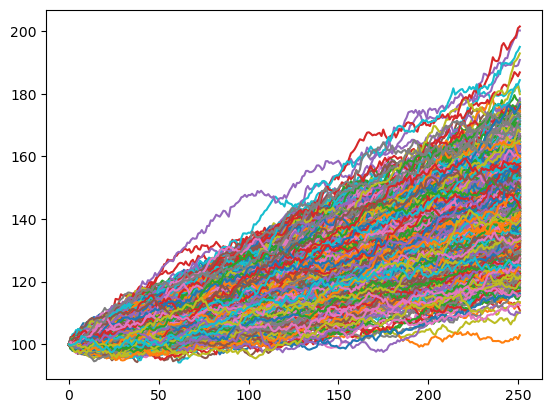

In [19]:
plt.plot(simulations)
plt.show()

# Optimisation du Levier

In [21]:
challenge = FTMOLeverageOptimazation(sigma=annual_volatility, mu=annual_mu, n_sim=10000, S0=100000)
challenge.optimize_leverage()

In [67]:
print(f"Levier optimal pour la phase 1 : {challenge.first_best_leverage}")
print(f"Probabilité de passer la phase 1 avec le levier optimal : {challenge.first_best_proba}")
print(80*'-')
print(f"Levier optimal pour la phase 2: {challenge.second_best_leverage}")
print(f"Probabilité de passer la phase 2 avec le levier optimal : {challenge.second_best_proba}")
print(80*'-')
print(f"Probabilité de passer les deux phases avec les leviers optimaux : {challenge.total_proba}")

Levier optimal pour la phase 1 : 4.421052796072243
Probabilité de passer la phase 1 avec le levier optimal : 0.6695
--------------------------------------------------------------------------------
Levier optimal pour la phase 2: 2.1229240117384394
Probabilité de passer la phase 2 avec le levier optimal : 0.9155
--------------------------------------------------------------------------------
Probabilité de passer les deux phases avec les leviers optimaux : 0.6129272499999999


In [3]:
from datetime import datetime

datetime.now().minute

51